In [1]:
import sys
from pathlib import Path

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'

### Model 1: Eight Layer Conv Net

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6406 | val loss: 1.3951 | accuracy: 49.03%
Validation loss decreased (inf --> 1.3951). Saving model.
[epoch 02] train loss: 1.1887 | val loss: 1.1398 | accuracy: 58.56%
Validation loss decreased (1.3951 --> 1.1398). Saving model.
[epoch 03] train loss: 0.9973 | val loss: 1.4422 | accuracy: 52.03%
EarlyStopping counter: 1 out of 3
[epoch 04] train loss: 0.8957 | val loss: 1.1119 | accuracy: 61.65%
Validation loss decreased (1.1398 --> 1.1119). Saving model.
[epoch 05] train loss: 0.7049 | val loss: 0.6644 | accuracy: 77.97%
Validation loss decreased (1.1119 --> 0.6644). Saving model.
[epoch 06] train loss: 0.6136 | val loss: 0.6094 | accuracy: 79.68%
Validation loss decreased (0.6644 --> 0.6094). Saving model.
[epoch 07] train loss: 0.5680 | val loss: 0.5911 | accuracy: 80.60%
Validation loss decreased (0.6094 --> 0.5911). Saving model.
[epoch 08] tra

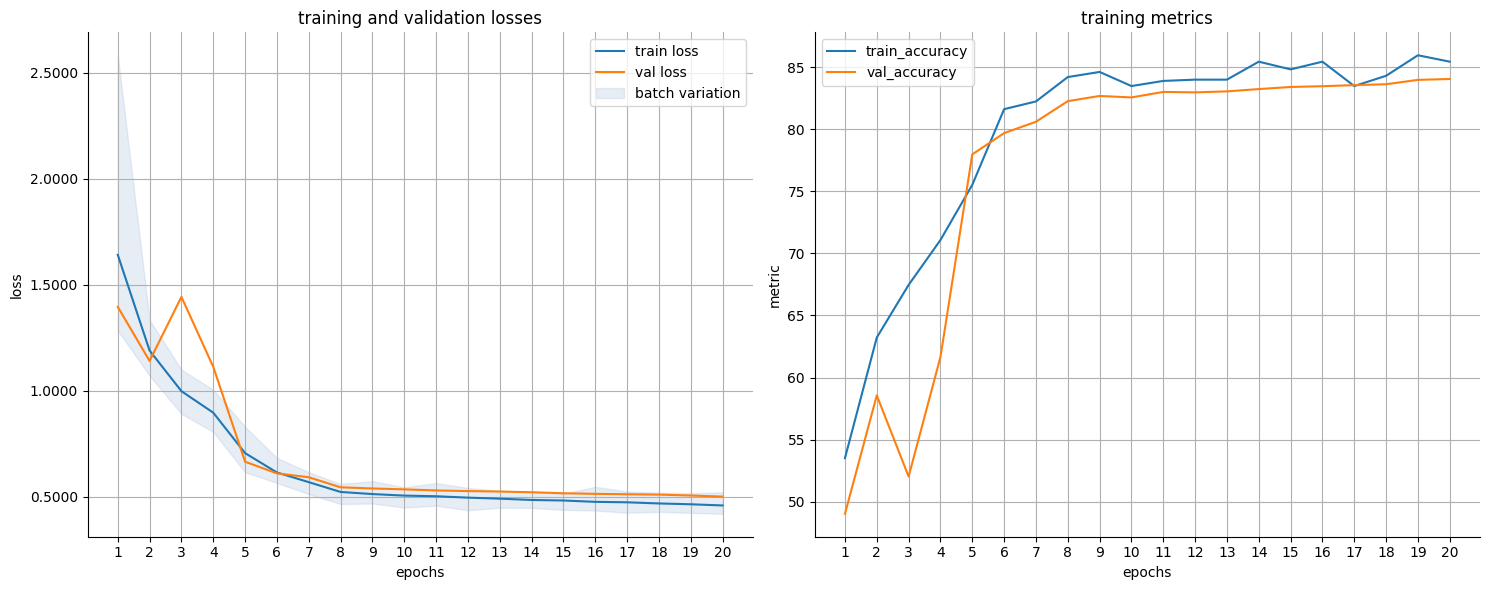

In [2]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.01,
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[8, 13],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = EightLayerConvNet()
trainer1 = train_model(model1, "EightLayerConvNet", num_epochs=20)

In [3]:
test_results_1 = trainer1.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation
Test Loss: 0.4924 | accuracy: 84.42


## Model 2: Eight Layer Conv Net Modified

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6263 | val loss: 1.3930 | accuracy: 49.84%
Validation loss decreased (inf --> 1.3930). Saving model.
[epoch 02] train loss: 1.1700 | val loss: 1.1359 | accuracy: 60.08%
Validation loss decreased (1.3930 --> 1.1359). Saving model.
[epoch 03] train loss: 0.9807 | val loss: 1.1271 | accuracy: 59.68%
Validation loss decreased (1.1359 --> 1.1271). Saving model.
[epoch 04] train loss: 0.8723 | val loss: 1.1029 | accuracy: 60.12%
Validation loss decreased (1.1271 --> 1.1029). Saving model.
[epoch 05] train loss: 0.8071 | val loss: 0.8835 | accuracy: 69.01%
Validation loss decreased (1.1029 --> 0.8835). Saving model.
[epoch 06] train loss: 0.6878 | val loss: 0.7759 | accuracy: 74.58%
Validation loss decreased (0.8835 --> 0.7759). Saving model.
[epoch 07] train loss: 0.6528 | val loss: 0.9512 | accuracy: 67.41%
EarlyStopping counter: 1 out of 5
[epoch 08] tra

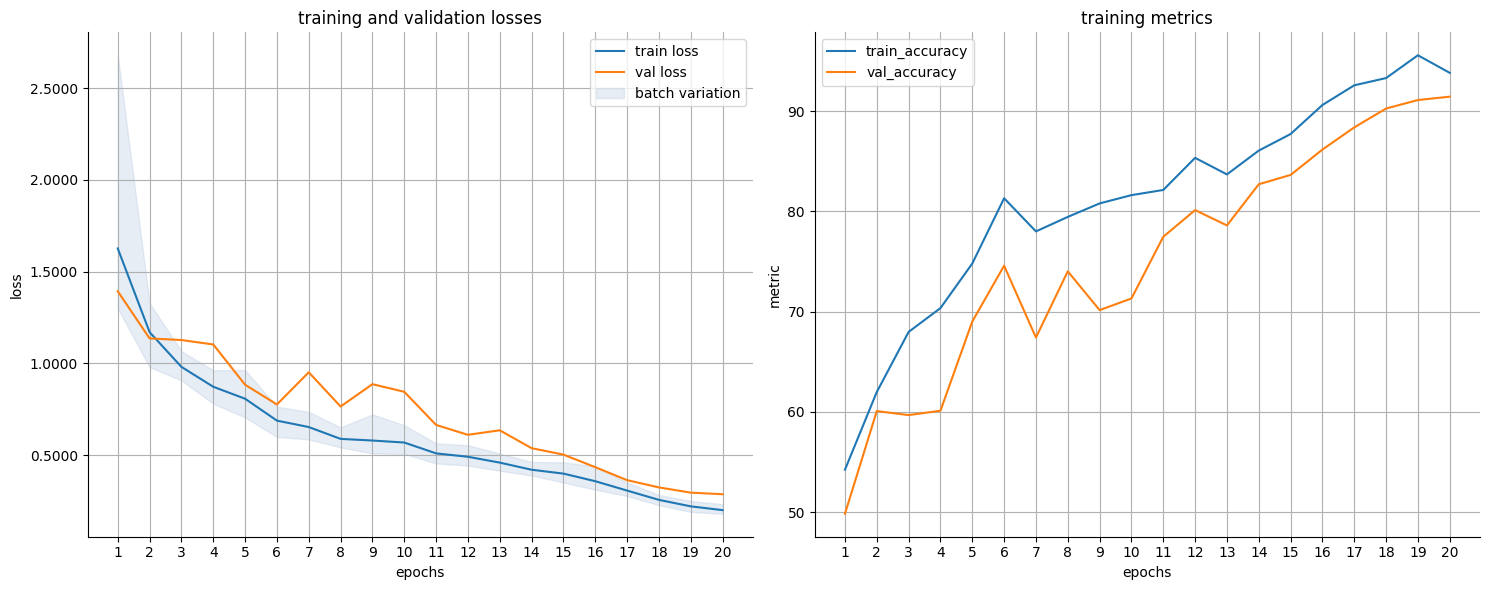

In [5]:
from models.mod_eight_layer_conv_net.architecture import ModEightLayerConvNet
from torch.optim.lr_scheduler import OneCycleLR
import math

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True
)

def train_model(model, model_name, num_epochs=200):

    max_lr = 0.1
    div_factor = 5          # controls initial LR: higher = lower start (max_lr/div_factor = 0.1/5 = 0.02)
    final_div_factor = 15   # controls decay speed: higher = faster decay (max_lr/final_div_factor = 0.1/15 ≈ 0.007)
    initial_lr = max_lr / div_factor
    
    # adjust warmup length based on absolute epochs, not percentage
    # absolute_warmup_epochs = 12
    # pct_start = absolute_warmup_epochs / num_epochs  # dynamically calculated
    pct_start = 0.23
   
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=0.01,
    )

    # calculate total steps
    steps_per_epoch = math.ceil(len(trainset) / 1024)
    total_steps = steps_per_epoch * num_epochs

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                     # (1) Peak learning rate
        total_steps=total_steps,           # (2) Total number of training iterations
        pct_start=pct_start,               # (3) Percentage of training spent in warmup
        div_factor=div_factor,             # (4) Initial LR division factor  (Initial LR = max_lr/div_factor = 0.1/5 = 0.02)
        final_div_factor=final_div_factor, # (5) Final LR division factor    (Final LR = max_lr/final_div_factor = 0.1/15 ≈ 0.007)
        anneal_strategy='cos'              # (6) Type of annealing (default 'cos')
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,

    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = ModEightLayerConvNet()
trainer2 = train_model(model2, "ModEightLayerConvNet", num_epochs=20)

In [6]:
test_results_2 = trainer2.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation


Test Loss: 0.2996 | accuracy: 90.93


### Model Performance Insights
#### Class Accuracies

Our analysis shows that cats, birds, and dogs have the lowest accuracy rates among all classes. Cats perform the worst with around 80% accuracy rate, while most other classes (excluding these three) achieve accuracies above 93%.

To better understand our model's weakness with cats, we need to investigate what the model is confusing them with. This leads us to our next question: What specific patterns are causing the model to struggle with cat classification?

To answer this, we need to examine the confusion matrix, which will provide more granular metrics. Several scenarios could explain this performance:
1. The model might be producing false positives (e.g., incorrectly classifying dogs as cats)
2. The model might be generating false negatives (e.g., missing actual cats and classifying them as other classes)

Since accuracy alone cannot reveal these patterns, our next step is to analyze the confusion matrix for a detailed view of these misclassifications.

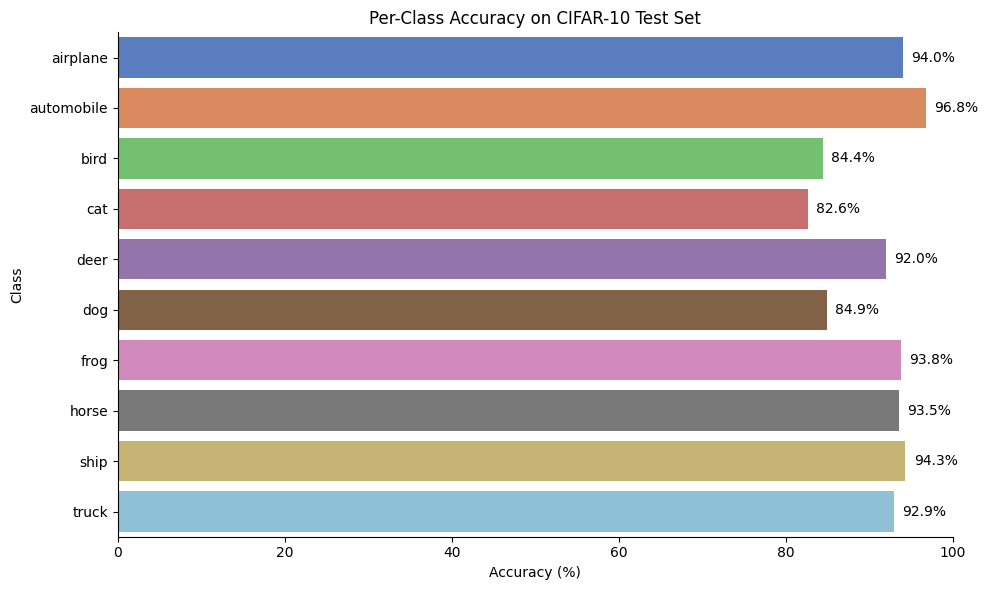

In [8]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_2['predictions']
true_labels = test_results_2['true_labels']

# calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)
for i in range(len(true_labels)):
    label = true_labels[i]
    class_total[label] += 1
    if predictions[i] == label:
        class_correct[label] += 1

per_class_accuracy = (class_correct / class_total) * 100

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

#### Confusion Matrix

The classification errors between cats and dogs appear to be bidirectional. The model frequently confuses cats with dogs and vice versa. 

As for birds, our third problematic class, the confusion is more distributed across various classes, though notably not with automobiles or trucks. 

While there are other patterns to explore, the cat/dog confusion stands out as the most significant issue. Given more time, we could investigate this further by implementing specialized data augmentations or more sophisticated convolution patterns to help the model better distinguish between these two classes. 

However, before considering such improvements, we need to deepen our understanding of the problem. Our next step is to examine the actual misclassified images to identify visual patterns that might explain the model's confusion. This analysis is crucial not only for understanding the current limitations but also for developing targeted solutions to improve the model's performance.

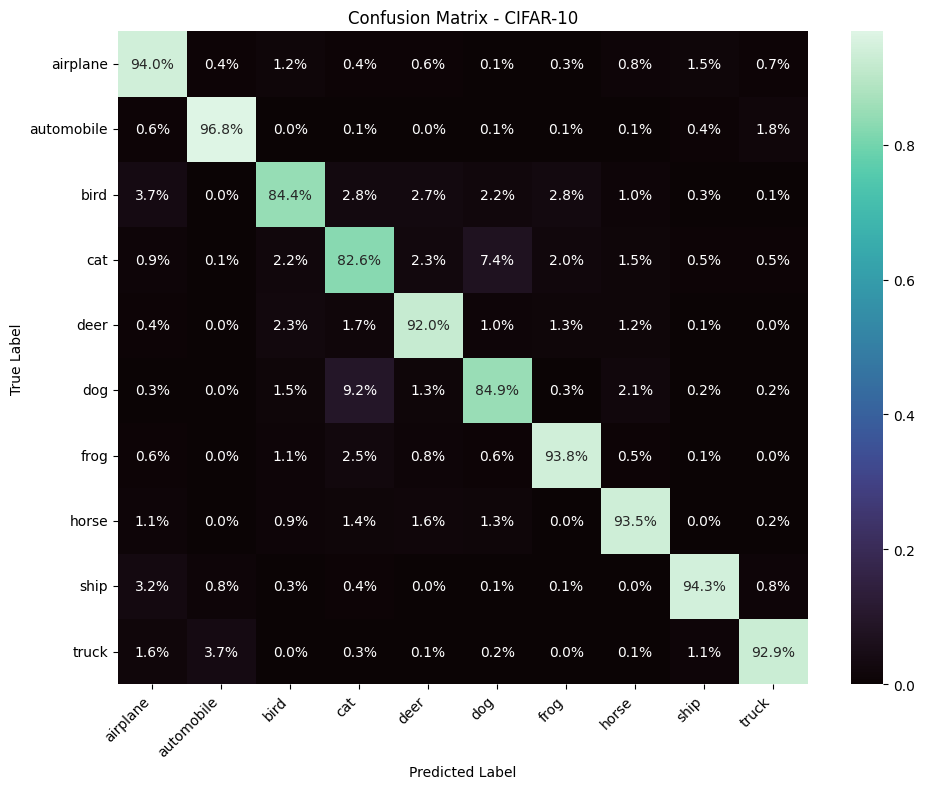

In [9]:
from matplotlib import pyplot as plt

# plot normalized confusion matrix
plotter.plot_confusion_matrix(
    predictions=predictions,
    true_labels=true_labels,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)

plt.tight_layout()

#### Classification Examples: Cats vs Dogs

Looking at these comparison images, we can see interesting patterns in how our model handles cats and dogs. We've arranged the examples to show both misclassifications and correct predictions, and each time we run this code, we get new random examples to analyze.

The confusion between cats and dogs makes sense when you look closely. Dogs with prominent, pointed ears often get mistaken for cats, and when cats take certain poses that are typically "dog-like," the model gets confused. This isn't too surprising since they share many physical characteristics - both are four-legged animals that can look quite similar in certain poses.

What's interesting is that when the model makes mistakes, it's often not very confident in its prediction. We see quite a few cases where the confidence is below 50%, which actually gives us hope - the model isn't confidently wrong, it's unsure. The main takeaways from looking through these examples are:
- Pointy-eared dogs often trigger cat predictions
- Cats in certain poses (especially with heads down) get classified as dogs
- When image quality is poor, mistakes are more common, but that's not really the model's fault

These insights could be valuable for future improvements to the model.

As a side note, our third "bonus model" (which uses transfer learning with EfficientNet-B4) shows some interesting improvements in this area. It handles the dog-to-cat confusion much better - when it sees a dog, it rarely mistakes it for a cat anymore. However, it's fascinating that even this more sophisticated model still struggles with cats, occasionally misclassifying them as dogs. This persistent cat-to-dog confusion suggests there might be something fundamentally challenging about certain cat features that even advanced architectures find tricky to handle.


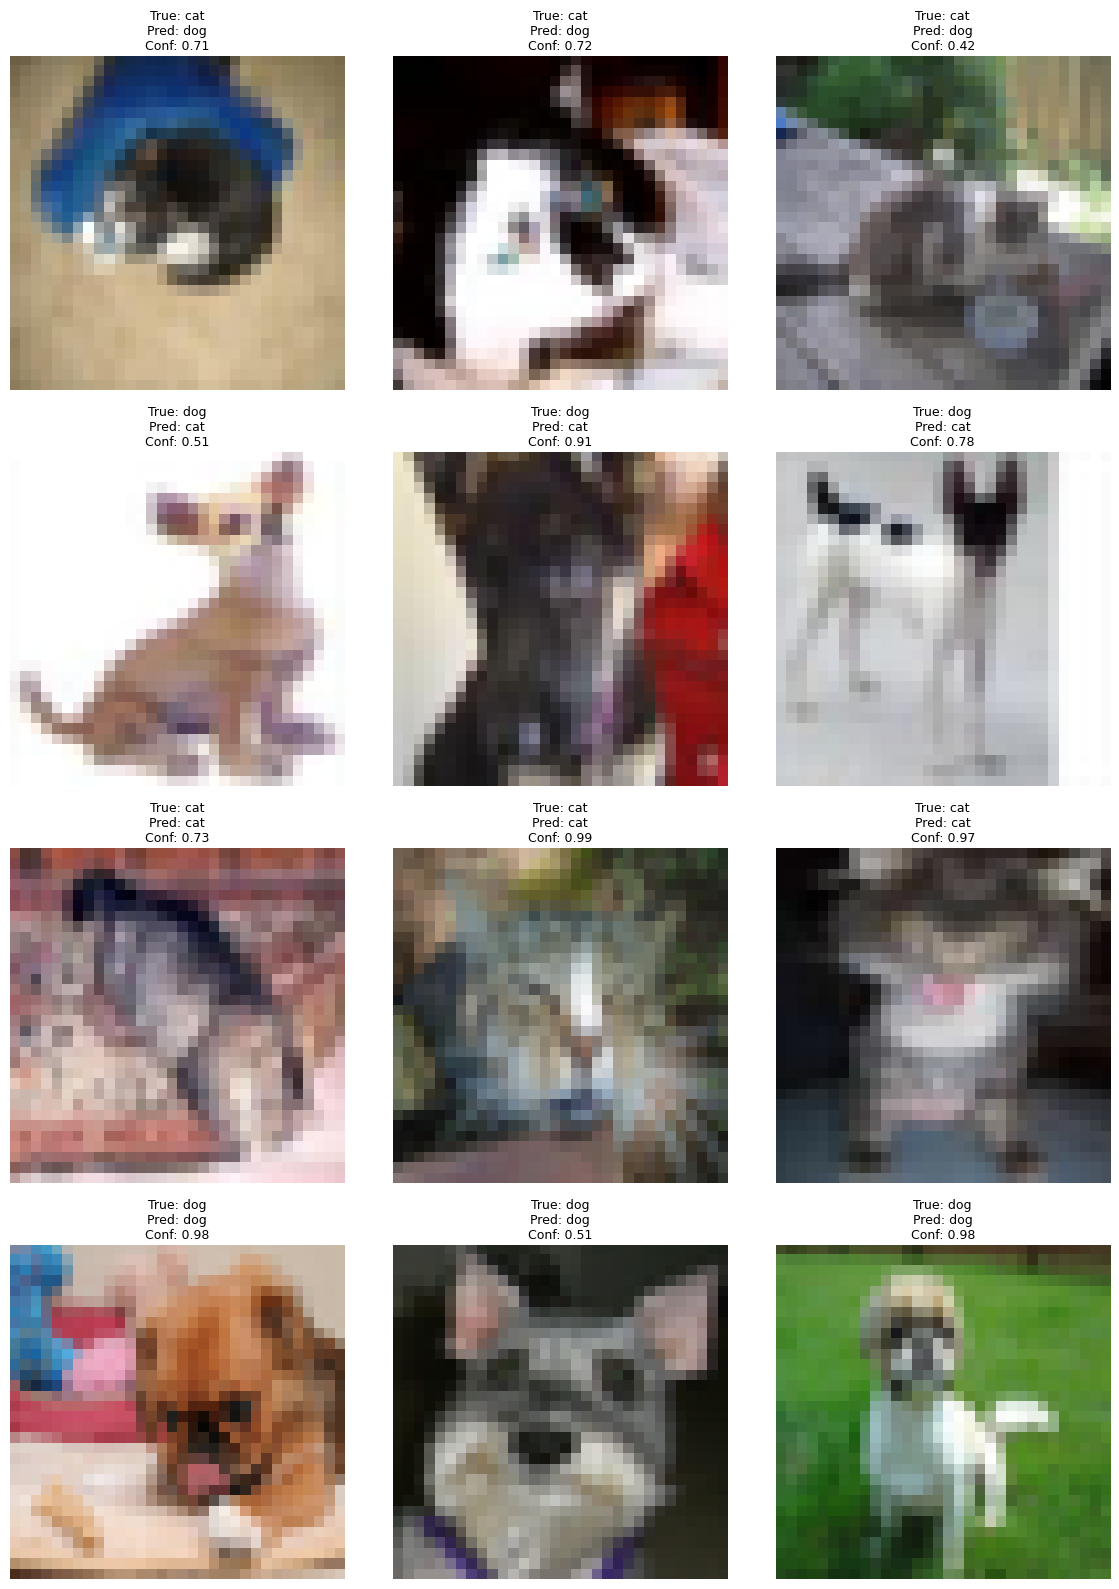

In [15]:
probabilities = test_results_2['probabilities']

# get images from test loader
images = []
for img, _ in test_results_2['test_loader']:
    images.extend(img.numpy())
images = np.array(images)

# create plotter
plotter = MetricsPlotter()

# Example 1: Look at cat-dog confusion
scenarios = [
    {'true': 'cat', 'pred': 'dog', 'n': 3},  # cats predicted as dogs
    {'true': 'dog', 'pred': 'cat', 'n': 3},  # dogs predicted as cats
    {'true': 'cat', 'pred': 'cat', 'n': 3},  # correctly classified cats
    {'true': 'dog', 'pred': 'dog', 'n': 3},  # correctly classified dogs
]

fig = plotter.plot_classification_examples(
    predictions=predictions,
    true_labels=true_labels,
    probabilities=probabilities,
    images=images,
    class_names=testset.classes,
    scenarios=scenarios
)

# fig.savefig('assets/classification_examples_cats_dogs.png')

### Bonus Model: Transfer Learning EfficientNet-B4

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b4
Using FP16 (half precision) training
[epoch 01] train loss: 0.4282 | val loss: 0.1369 | accuracy: 95.44%
Validation loss decreased (inf --> 0.1369). Saving model.


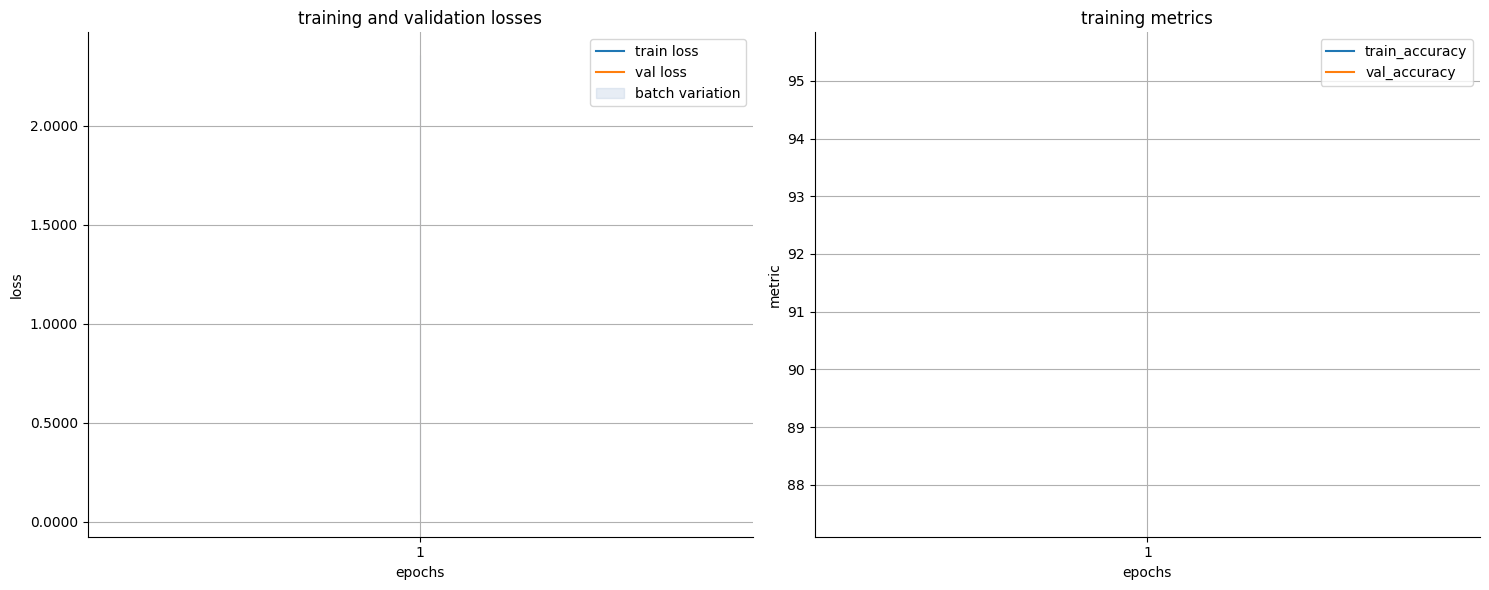

In [60]:
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=160, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

model3 = EfficientNet.from_pretrained('efficientnet-b4', num_classes=10)

optimizer = SGD(
    model3.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6
)

scheduler = StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

trainer3 = ModelTrainer(
    model=model3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=32,
    verbose=True,
    save_metrics=False,
    early_stopping_patience=float('inf'),
    metrics=[accuracy],
    log_dir="logs/EfficientNet",
    logger_type="file"
)

trained_model3 = trainer3.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=30
)

In [61]:
test_results_efficientnet = trainer3.evaluate_on_test(test_set=testset)

Loading Best Model for Test Evaluation
Test Loss: 0.1311 | accuracy: 95.87


Loading Best Model for Test Evaluation
Test Loss: 0.1311 | accuracy: 95.87


<Axes: title={'center': 'Confusion Matrix - CIFAR-10'}, xlabel='Predicted Label', ylabel='True Label'>

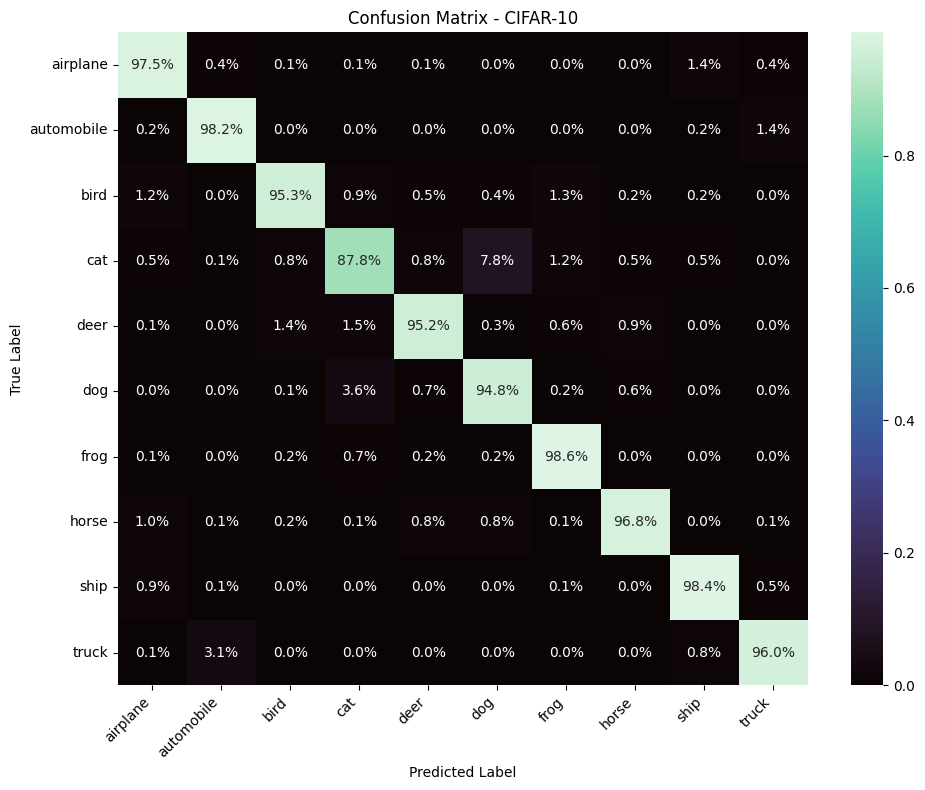

In [62]:
predictions_efficientnet = test_results_efficientnet['predictions']
true_labels_efficientnet = test_results_efficientnet['true_labels']

ax = plotter.plot_confusion_matrix(
    predictions=predictions_efficientnet,
    true_labels=true_labels_efficientnet,
    class_names=testset.classes,
    dataset_name="CIFAR-10",
    normalize=True,
    cmap='mako'
)